In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

import gdax
public_client = gdax.PublicClient()

In [2]:
currency = "BCH"
base = "EUR"
pair = "{}-{}".format(currency, base)

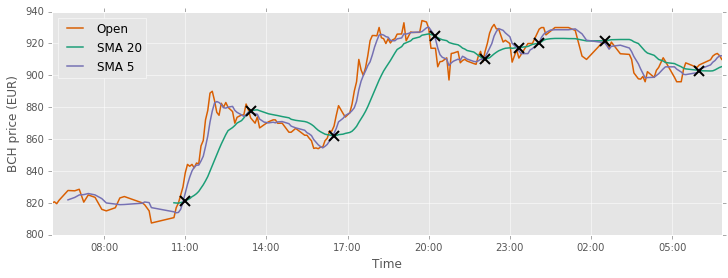

In [3]:
#print public_client.get_product_24hr_stats(pair)
unit = 300
columns = [ "time", "low", "high", "open", "close", "volume" ]
data = pd.DataFrame(public_client.get_product_historic_rates(pair,
                                                             granularity=unit),
                    columns=columns).drop(labels=["low", "high", "close", "volume"], axis=1)
#data.set_index("time", inplace=True)
#data.head()
data["time"] = pd.to_datetime(data["time"], unit="s")
data.set_index("time", inplace=True)
#data.head()
#data = data[["time", "open", "high", "low", "close"]]

cs = ['#d95f02','#1b9e77','#7570b3','#e7298a']
lw = 1.5

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(data, label="Open", color=cs[0], lw=lw)
ax.set_ylabel("{} price ({})".format(currency, base))
ax.set_xlabel("Time")

hfmt = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hfmt)

#Series.rolling(window=50,center=False).mean()
sma_labels = [20, 5]
smas = []
for i, s in enumerate(sma_labels):
    smas.append(data["open"][::-1].rolling(window=s, center=False).mean())
    ax.plot(smas[i], label="SMA {}".format(s), color=cs[i+1], lw=lw)
ax.legend(loc="best")

intersections = np.concatenate(([0],np.diff(np.sign(smas[0] - smas[1]))))
intersections[np.isnan(intersections)] = 0
intersect_pts = smas[0][intersections!=0]
ax.plot(intersect_pts, "x", ms=10, mew=2, color="black")

In [18]:
# Run the stragey (assuming no trading fees)
# Still need to automate the process of ending with a EUR balance
times = intersect_pts.index
long_position = (intersections[intersections!=0][0] < 0)
print "Starting long:", long_position, "\n"
total_eur = 1000.
total_bch = 0.
for t in times[:-1]:
    price = data["open"].loc[t]
    print price, "\n"
    if long_position:
        total_bch += total_eur / price
        total_eur = 0.
        long_position = False
    else:
        total_eur += total_bch * price
        total_bch = 0.
        long_position = True
    print "EUR:", total_eur
    print "BCH:", total_bch, "\n"

print "Final EUR:", total_eur

Starting long: True 

838.75 

EUR: 0.0
BCH: 1.19225037258 

873.4 

EUR: 1041.31147541
BCH: 0.0 

868.12 

EUR: 0.0
BCH: 1.19950176866 

917.0 

EUR: 1099.94312186
BCH: 0.0 

915.0 

EUR: 0.0
BCH: 1.20212363045 

910.85 

EUR: 1094.9543088
BCH: 0.0 

928.99 

EUR: 0.0
BCH: 1.17865026405 

922.02 

EUR: 1086.73911646
BCH: 0.0 

Final EUR: 1086.73911646
